In [1]:
import pandas as pd
import numpy as np
from linearmodels import PanelOLS
import warnings
# the feature of STATA 17 SE is used to run the stata codes in the jupyter notebook
# this is because the python package cannot handle three-way fixed effects and reghdfe is needed 
# the stata codes can also be run in the stata program 
import stata_setup

stata_setup.config("C:\Program Files\Stata17", "se")
warnings.filterwarnings('ignore')

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject



  ___  ____  ____  ____  ____ ®
 /__    /   ____/   /   ____/      17.0
___/   /   /___/   /   /___/       SE—Standard Edition

 Statistics and Data Science       Copyright 1985-2021 StataCorp LLC
                                   StataCorp
                                   4905 Lakeway Drive
                                   College Station, Texas 77845 USA
                                   800-STATA-PC        https://www.stata.com
                                   979-696-4600        stata@stata.com

Stata license: Single-user , expiring 17 Feb 2024
Serial number: 401709210983
  Licensed to: Dian
               Columbia Business School

Notes:
      1. Unicode is supported; see help unicode_advice.
      2. Maximum number of variables is set to 5,000; see help set_maxvar.


In [4]:
# CRSP/Compustat Merged - Fundamentals Annual
# https://wrds-www.wharton.upenn.edu/pages/get-data/center-research-security-prices-crsp/annual-update/crspcompustat-merged/fundamentals-annual/?saved_query=2861041
funda = pd.read_csv('funda2.csv.gz') 
# CRSP/Compustat Merged - Fundamentals Quarterly
# https://wrds-www.wharton.upenn.edu/pages/get-data/center-research-security-prices-crsp/quarterly-update/crspcompustat-merged/fundamentals-quarterly/?saved_query=2862850
fundq = pd.read_csv('fundq.csv.gz')
# CRSP - Daily Stock File
# https://wrds-www.wharton.upenn.edu/pages/get-data/center-research-security-prices-crsp/annual-update/stock-version-2/daily-stock-file/?saved_query=2861103
crsp = pd.read_csv('crsp.csv.zip')

In [5]:
'''
preliminary cleaning 
crsp: add a column for squared daily return
fundq: calculate quarterly cash-flow-to-asset ratio
funda: filter out the companies excluded in the paper (we use funda to build and merge the full datasets, so we don't need to repeat the filtering for 
crsp and fundq)
'''

crsp['cyear'] = crsp['DlyCalDt'].apply(lambda x: x[:4]).astype(int)
# the paper requires that the standard deviation be calculated using annualized average sum of squares
crsp['ret2'] = crsp['DlyRet']**2

# create the indexing for year-quarter
fundq['yearq'] = fundq['fyearq'] + (fundq['fqtr'] - 1) / 4
fundq = fundq.sort_values(['gvkey', 'yearq']).reset_index(drop=True)
fundq['accruals'] = fundq.groupby(['gvkey'])['actq'].diff() - fundq.groupby(['gvkey'])['cheq'].diff() - fundq.groupby(['gvkey'])['lctq'].diff() \
    + fundq.groupby(['gvkey'])['dlcq'].diff() - fundq['dpq']
# remove the observations with missing last-quarter data (i.e., the difference in year-quarter indexing is not 0.25)
fundq.loc[fundq.groupby(['gvkey'])['yearq'].diff() != .25, 'accruals'] = np.nan
# quarterly cash-flow-to-asset ratio
fundq['cf2a'] = (fundq['oiadpq'] - fundq['accruals']) / fundq.groupby(['gvkey'])['atq'].shift(1)
fundq = fundq.rename(columns={'gvkey': 'GVKEY'})

# remove egulated utility firms (SIC codes 4900–4999)
funda = funda[~((funda['sic']>=4900)&(funda['sic']<=4999))]
# remove firms located or incorporated outside the US (built on sample STATA codes)
state_list = 'keep if incorp == "AK" | incorp == "AL" | incorp == "AR" | incorp == "AZ" | incorp == "CA" | incorp == "CO" | incorp == "CT" | incorp == "DC" | incorp == "DE" | incorp == "FL" | incorp == "GA" | incorp == "HI" | incorp == "ID" | incorp == "IL" | incorp == "IN" | incorp == "IA" | incorp == "KS" | incorp == "KY" | incorp == "LA" | incorp == "ME" | incorp == "MD" | incorp == "MA" | incorp == "MI" | incorp == "MN" | incorp == "MS" | incorp == "MO" | incorp == "MT" | incorp == "NE" | incorp == "NV" | incorp == "NH" | incorp == "NJ" | incorp == "NM" | incorp == "NY" | incorp == "NC" | incorp == "ND" | incorp == "OH" | incorp == "OK" | incorp == "OR" | incorp == "PA" | incorp == "RI" | incorp == "SC" | incorp == "SD" | incorp == "TN" | incorp == "TX" | incorp == "UT" | incorp == "VT" | incorp == "VA" | incorp == "WA" | incorp == "WV" | incorp == "WI" | incorp == "WY"'
state_list = state_list.split('"')[1::2]
funda = funda[funda['state'].isin(state_list)]
funda = funda[funda['incorp'].isin(state_list)]
# remove firm-year observations with either missing or negative assets or sales
funda = funda[funda['sale'] > 0]
funda = funda[funda['at'] > 0] 

In [6]:
'''
merge the datasets from CRSP and Fundamentals Quarterly to the dataset from Fundamentals Annual
what we need from CRSP: annualized vol of stock return 
what we need from Fundamentals Quarterly: annual vol of cash-flow-to-asset ratio
'''

df1 = crsp.groupby(['cyear', 'PERMNO'])['ret2'].mean().reset_index()
df1.columns = ['fyear', 'LPERMNO', 'ret_vol']
df1['ret_vol'] = np.sqrt(df1['ret_vol'] * 252)

df2 = fundq.groupby(['GVKEY', 'fyearq'])['cf2a'].std().reset_index()
df2.columns = ['GVKEY', 'fyear', 'cf_vol']

# use gvkey, the primary identifier of Compustat, to merge funda and fundq to ensure best match
df = pd.merge(funda, df2, how='left')
# use LPERMNO to merge funda and crsp, as provided by the CRSP/Compustat Merged Database
df = pd.merge(df, df1, how='left')
df = df.sort_values(['GVKEY', 'fyear']).reset_index(drop=True)

In [7]:
'''
Main variables of interest
'''

# ln(assets): Calculated from Compustat using ln(at)
df['ln_assets'] = np.log(df['at'])

# ROA: Calculated from Compustat using ni / at
df['roa'] = df['ni'] / df['at']

# debt/assets: Calculated from Compustat using (dltt + dlc) / at
df['leverage'] = (df['dltt'] + df['dlc']) / df['at']

# three-year asset CAGR: Calculated from Compustat using [$(at_t / at_{t-3})^{1/3}$ − 1] × 100; CAGR = compounded annual growth rate.
df['asset_cagr'] = ((df['at'] / df.groupby(['LPERMNO'])['at'].shift(3)) ** (1/3) - 1) * 100
# replace the 3-year growth rate where year t-3 is missing with NaN
df.loc[df['fyear'] - df.groupby(['LPERMNO'])['fyear'].shift(3) != 3, 'asset_cagr'] = np.nan

# ln(cash): Calculated from Compustat using ln(ch).
df['ln_cash'] = np.log(df['ch'])

# stock volatitily: ret_vol from df1
# Calculated from CRSP using the square root of the sum of squared daily returns over the year. 
# To adjust for differences in the number of trading days, the raw sum is multiplied by 252 and divided by the number of trading days

# Cash flow/Assets: Calculated from Compustat using $(oiadp_t - accruals_t) / at_{t−1}$, where $accruals_t = (act_t − act_{t−1}) − (che_t − che_{t−1}) − (lct_t − lct_{t−1}) + (dlc_t − dlc_{t−1}) − dp_t$.
# df['cf_vol'] merged from df2

# operating asset volatity: Stock volatility × [E / (V − C)], where E / (V − C) is calculated from Compustat using (csho × prcc_f) / [lt + (csho × prcc_f) − ch]
df['oav'] = df['csho'] * df['prcc_f'] / (df['lt'] + df['csho'] * df['prcc_f'] - df['ch']) * df['ret_vol']

# replace infinities with NaN (this might arise from division by 0, logarithm of 0, etc.)
df = df.replace([np.inf, -np.inf], np.nan)

In [8]:
'''
create the main variable: BC Law
the computation is based on Table A1 of the paper
'''

bc_state = ['AZ', 'CT', 'DE', 'GA', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'ME', 'MD', 'MA', 'MI', 'MN', 'MO', 'NE', 'NV', 
'NJ', 'NY', 'OK', 'OH', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'VA', 'WA', 'WI', 'WY']
bc_year = [1987, 1989, 1988, 1988, 1988, 1989, 1986, 1997, 1989, 1987, 1988, 1989, 1989, 1989, 1987, 1986, 1988, 1991, 
1986, 1985, 1991, 1990, 1991, 1989, 1990, 1988, 1990, 1988, 1997, 1988, 1987, 1987, 1989]

bc_dict = dict(zip(bc_state, bc_year))

df['bc_year'] = df['incorp'].apply(lambda x: bc_dict[x] if x in bc_dict.keys() else 2100)
df['bc_law'] = (df['fyear'] >= df['bc_year']).astype(int)

In [9]:
'''
produce the final dataset
'''
# take the sample period (data from 1970 to 2009 in the original dataset is downloaded in case of other needs)
df = df[(df['fyear']>=1976)&(df['fyear']<=2006)]

# winsorize the numerical features on 1% level (into 99% interval)
numerical = ['ln_assets', 'roa', 'leverage', 'asset_cagr', 'ret_vol', 'cf_vol', 'ln_cash', 'oav']
df[numerical] = df[numerical].clip(lower=df[ numerical].quantile(0.005), upper=df[numerical].quantile(0.995), axis=1).values
df.to_stata('reg.dta')

In [10]:
'''
replication of table 1, columns 1 and 2 (this is not required, provided to check the data consistency)
'''

col1 = df[(df['bc_year']==df['fyear']+1)|(df['bc_year']==df['fyear']+2)|(df['bc_year']==df['fyear']+3)]
col2 = df[df['fyear'].isin(col1['fyear'].values)&(df['bc_year']!=df['fyear']+1)&(df['bc_year']!=df['fyear']+2)&(df['bc_year']!=df['fyear']+3)]

table1 = pd.DataFrame(columns=['', 'BC law', 'No BC law'])

for var in ['ln_assets', 'roa', 'leverage', 'asset_cagr', 'ret_vol', 'cf_vol']:
    table1 = table1.append(pd.Series([var, 
                                      '%.3f' % col1[var].mean(), 
                                      '%.3f' % col2[var].mean()], index=table1.columns), ignore_index=True)
    table1 = table1.append(pd.Series(['', '(%.3f)' % col1[var].std(), '(%.3f)' % col2[var].std()], index=table1.columns), ignore_index=True)

table1 = table1.append(pd.Series(['N', len(col1), len(col2)], index=table1.columns), ignore_index=True)
table1.to_csv('table1.csv', index=False)

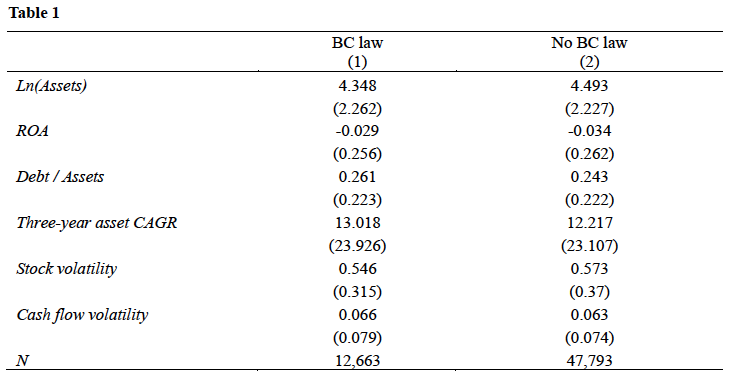

In [11]:
'''
replication of table A3, rows 1, 3, 4 and 5 (this is not required, provided to check the data consistency)
'''

tablea3 = df[['ret_vol', 'oav', 'cf_vol', 'ln_cash']].agg([np.mean, np.median, np.std]).T
tablea3.round(3)
tablea3.to_csv('tablea3.csv')

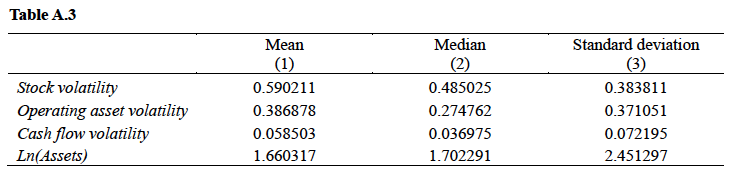

In [15]:
%%stata
* replication of table 2, columns 1, 3, 4 and 5

set matsize 2000, permanently
use reg.dta, clear

egen state_year = group(fyear state)
egen industry_year = group(fyear sic)

quietly reghdfe ret_vol bc_law, absorb(GVKEY state_year industry_year) cluster(incorp) noconstant
outreg2 using table2.xls, se tdec(2) bdec(3) addstat(Adj. R-squared, e(r2_a))addtext(Firm-Fixed Effects, Yes, State-Year-Fixed Effects, Yes, Industry-Year-Fixed Effects, Yes, Cluster, State-of-Incorp) replace

quietly reghdfe oav bc_law, absorb(GVKEY state_year industry_year) cluster(incorp) noconstant
outreg2 using table2.xls, se tdec(2) bdec(3) addstat(Adj. R-squared, e(r2_a))addtext(Firm-Fixed Effects, Yes, State-Year-Fixed Effects, Yes, Industry-Year-Fixed Effects, Yes, Cluster, State-of-Incorp) append
 
quietly reghdfe cf_vol bc_law, absorb(GVKEY state_year industry_year) cluster(incorp) noconstant
outreg2 using table2.xls, se tdec(2) bdec(3) addstat(Adj. R-squared, e(r2_a))addtext(Firm-Fixed Effects, Yes, State-Year-Fixed Effects, Yes, Industry-Year-Fixed Effects, Yes, Cluster, State-of-Incorp) append

quietly reghdfe ln_cash bc_law, absorb(GVKEY state_year industry_year) cluster(incorp) noconstant
outreg2 using table2.xls, se tdec(2) bdec(3) addstat(Adj. R-squared, e(r2_a))addtext(Firm-Fixed Effects, Yes, State-Year-Fixed Effects, Yes, Industry-Year-Fixed Effects, Yes, Cluster, State-of-Incorp) append


. * replication of table 2, columns 1, 3, 4 and 5
. 
. set matsize 2000, permanently
(set matsize preference recorded)
set matsize ignored.
    Matrix sizes are no longer limited by c(matsize) in modern Statas.
    Matrix sizes are now limited by edition of Stata.  See limits for more
    details.

. use reg.dta, clear

. 
. egen state_year = group(fyear state)

. egen industry_year = group(fyear sic)

. 
. quietly reghdfe ret_vol bc_law, absorb(GVKEY state_year industry_year) cluste
> r(incorp) noconstant

. outreg2 using table2.xls, se tdec(2) bdec(3) addstat(Adj. R-squared, e(r2_a))
> addtext(Firm-Fixed Effects, Yes, State-Year-Fixed Effects, Yes, Industry-Year
> -Fixed Effects, Yes, Cluster, State-of-Incorp) replace
table2.xls
dir : seeout

. 
. quietly reghdfe oav bc_law, absorb(GVKEY state_year industry_year) cluster(in
> corp) noconstant

. outreg2 using table2.xls, se tdec(2) bdec(3) addstat(Adj. R-squared, e(r2_a))
> addtext(Firm-Fixed Effects, Yes, State-Year-Fixed Effects, 

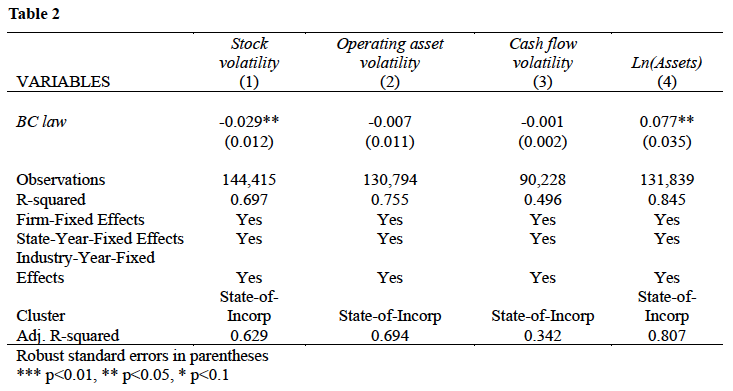